# Revised Phase 4: Mitigation Experiments

**Objective**: Improve performance on 3-class (Negative, Neutral, Positive) sentiment classification on the Bangla Sentiment Dataset by applying imbalanced learning strategies, including data-level (SMOTE, Random Undersampling, NearMiss) and algorithm-level (Weighted Loss) methods. Train and tune Logistic Regression, SVM, Naive Bayes, and Random Forest, with comprehensive evaluations and visualizations (confusion matrices, ROC-AUC curves, precision-recall curves, F1 comparisons) to assess mitigation effectiveness.

In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import os
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


# Define paths
data_dir = "text_representation/"
files = {
    'tfidf_train': f"{data_dir}tfidf_train.npz",
    'tfidf_val': f"{data_dir}tfidf_val.npz",
    'tfidf_test': f"{data_dir}tfidf_test.npz",
    'labels_train': f"{data_dir}labels_train.csv",
    'labels_val': f"{data_dir}labels_val.csv",
    'labels_test': f"{data_dir}labels_test.csv"
}

# Check file existence
for name, path in files.items():
    if not os.path.exists(path):
        logging.error(f"Missing file: {path}")
        raise FileNotFoundError(f"Missing file: {path}")

# Load TF-IDF matrices
tfidf_train = sp.load_npz(files['tfidf_train'])
tfidf_val = sp.load_npz(files['tfidf_val'])
tfidf_test = sp.load_npz(files['tfidf_test'])
logging.info("TF-IDF matrices loaded successfully")

# Load labels
y_train = pd.read_csv(files['labels_train'], encoding='utf-8')['Label'].values
y_val = pd.read_csv(files['labels_val'], encoding='utf-8')['Label'].values
y_test = pd.read_csv(files['labels_test'], encoding='utf-8')['Label'].values
logging.info("Labels loaded successfully")

# Validate shapes
assert tfidf_train.shape[0] == len(y_train), "Train data mismatch"
assert tfidf_val.shape[0] == len(y_val), "Validation data mismatch"
assert tfidf_test.shape[0] == len(y_test), "Test data mismatch"
logging.info("Data shapes validated")

# Print shapes and distribution
print("TF-IDF Train Shape:", tfidf_train.shape)
print("Labels Train Shape:", y_train.shape)
print("Label Distribution (Train):\n", pd.Series(y_train).value_counts(normalize=True) * 100)

2025-06-24 05:02:03,217 - INFO - TF-IDF matrices loaded successfully
2025-06-24 05:02:03,231 - INFO - Labels loaded successfully
2025-06-24 05:02:03,233 - INFO - Data shapes validated


TF-IDF Train Shape: (6193, 5000)
Labels Train Shape: (6193,)
Label Distribution (Train):
 0    47.359922
2    29.081221
1    23.558857
Name: proportion, dtype: float64


### Step 1: Apply Data-Level Mitigation Techniques

- **Objective**: Generate mitigated datasets using SMOTE (oversampling), Random Undersampling, and NearMiss (undersampling).

In [5]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.utils.class_weight import compute_class_weight
import scipy.sparse as sp
import pandas as pd
import numpy as np
import logging
import os
import json

# ========== Configuration ==========
DATA_DIR = "mitigated_datasets"
os.makedirs(DATA_DIR, exist_ok=True)

# Replace with your actual data
# tfidf_train = ...
# y_train = ...

# ========== Logging ==========
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# ========== Helper Function ==========
def apply_and_save_resampler(resampler, name: str, X, y):
    X_res, y_res = resampler.fit_resample(X, y)
    sp.save_npz(f"{DATA_DIR}/tfidf_train_{name}.npz", X_res, compressed=True)
    pd.DataFrame({'Label': y_res}).to_csv(f"{DATA_DIR}/labels_train_{name}.csv", index=False)
    logging.info(f"{name.capitalize()} dataset saved with shape {X_res.shape}")
    return X_res, y_res

# ========== Apply Resampling Techniques and Store ==========
tfidf_train_smote, y_train_smote = apply_and_save_resampler(SMOTE(random_state=42), "smote", tfidf_train, y_train)
tfidf_train_under, y_train_under = apply_and_save_resampler(RandomUnderSampler(random_state=42), "undersampled", tfidf_train, y_train)
tfidf_train_nearmiss, y_train_nearmiss = apply_and_save_resampler(NearMiss(version=1, n_neighbors=3), "nearmiss", tfidf_train, y_train)

# ========== Compute and Save Class Weights ==========
classes = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights = {int(k): float(v) for k, v in zip(classes, weights)}

with open(f"{DATA_DIR}/class_weights.json", "w") as f:
    json.dump(class_weights, f, indent=4)

logging.info(f"Class weights computed and saved: {class_weights}")

# ========== Define Datasets ==========
datasets = {
    'smote': (tfidf_train_smote, y_train_smote),
    'undersampled': (tfidf_train_under, y_train_under),
    'nearmiss': (tfidf_train_nearmiss, y_train_nearmiss),
    'weighted': (tfidf_train_smote, y_train_smote)  # Same data, different usage
}

2025-06-24 05:11:47,040 - INFO - Smote dataset saved with shape (8799, 5000)
2025-06-24 05:11:47,112 - INFO - Undersampled dataset saved with shape (4377, 5000)
2025-06-24 05:11:47,478 - INFO - Nearmiss dataset saved with shape (4377, 5000)
2025-06-24 05:11:47,483 - INFO - Class weights computed and saved: {0: 0.7038299806796227, 1: 1.4148960475211332, 2: 1.1462150657042385}


### Step 2: Retrain Logistic Regression, SVM, Naive Bayes, and Random Forest

- **Objective**: Train models on mitigated datasets (SMOTE, Random Undersampling, NearMiss) and apply weighted loss to all models

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import joblib
from tqdm import tqdm
import os
import logging
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Create output directory
os.makedirs("models/mitigated_models", exist_ok=True)
logging.info("Output directory created: models/mitigated_models")

# Initialize models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, penalty='l2', random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'NaiveBayes': MultinomialNB(),
    'RandomForest': RandomForestClassifier(random_state=42)
}

# Supported class_weight models
supports_class_weight = {'LogisticRegression', 'SVM', 'RandomForest'}

# Store metrics
results = []

for dataset_name, (X_train, y_train) in tqdm(datasets.items(), desc="Training Datasets"):
    for name, model in models.items():
        try:
            # Clone and configure model
            model_copy = model.__class__(**model.get_params())
            if dataset_name == 'weighted' and name in supports_class_weight:
                model_copy.set_params(class_weight=class_weights)

            # Train
            model_copy.fit(X_train, y_train)

            # Save model
            model_path = f"models/mitigated_models/{name}_{dataset_name}.joblib"
            joblib.dump(model_copy, model_path)
            logging.info(f"{name} ({dataset_name}) trained and saved")

            # Validate
            y_pred = model_copy.predict(tfidf_val)

            metrics = {
                'Model': name,
                'Dataset': dataset_name,
                'Accuracy': accuracy_score(y_val, y_pred),
                'Precision': precision_score(y_val, y_pred, average='weighted', zero_division=0),
                'Recall': recall_score(y_val, y_pred, average='weighted', zero_division=0),
                'F1-Score': f1_score(y_val, y_pred, average='weighted', zero_division=0),
            }
            results.append(metrics)

        except Exception as e:
            logging.error(f"Error training {name} ({dataset_name}): {str(e)}")

# Display metrics as table
metrics_df = pd.DataFrame(results)
print("\nValidation Metrics:\n")
print(metrics_df.to_string(index=False))

2025-06-24 05:26:52,961 - INFO - Output directory created: models/mitigated_models
Training Datasets:   0%|          | 0/4 [00:00<?, ?it/s]2025-06-24 05:26:57,350 - INFO - LogisticRegression (smote) trained and saved
2025-06-24 05:28:42,016 - INFO - SVM (smote) trained and saved
2025-06-24 05:28:43,324 - INFO - NaiveBayes (smote) trained and saved
2025-06-24 05:29:04,832 - INFO - RandomForest (smote) trained and saved
Training Datasets:  25%|██▌       | 1/4 [02:11<06:35, 131.95s/it]2025-06-24 05:29:05,197 - INFO - LogisticRegression (undersampled) trained and saved
2025-06-24 05:29:32,313 - INFO - SVM (undersampled) trained and saved
2025-06-24 05:29:32,854 - INFO - NaiveBayes (undersampled) trained and saved
2025-06-24 05:29:43,236 - INFO - RandomForest (undersampled) trained and saved
Training Datasets:  50%|█████     | 2/4 [02:50<02:33, 76.94s/it] 2025-06-24 05:29:44,519 - INFO - LogisticRegression (nearmiss) trained and saved
2025-06-24 05:30:10,334 - INFO - SVM (nearmiss) trained 


Validation Metrics:

             Model      Dataset  Accuracy  Precision   Recall  F1-Score
LogisticRegression        smote  0.554839   0.556895 0.554839  0.555383
               SVM        smote  0.607742   0.623634 0.607742  0.582523
        NaiveBayes        smote  0.574194   0.572901 0.574194  0.573476
      RandomForest        smote  0.570323   0.564537 0.570323  0.560101
LogisticRegression undersampled  0.543226   0.550404 0.543226  0.545721
               SVM undersampled  0.572903   0.571313 0.572903  0.571782
        NaiveBayes undersampled  0.566452   0.569048 0.566452  0.567543
      RandomForest undersampled  0.547097   0.549483 0.547097  0.548132
LogisticRegression     nearmiss  0.521290   0.538008 0.521290  0.522455
               SVM     nearmiss  0.535484   0.548655 0.535484  0.537571
        NaiveBayes     nearmiss  0.572903   0.576488 0.572903  0.572369
      RandomForest     nearmiss  0.485161   0.498891 0.485161  0.486892
LogisticRegression     weighted  0.486452 

### Step 3: Hyperparameter Tuning

- **Objective**: Tune Logistic Regression, SVM, Naive Bayes, and Random Forest on mitigated datasets.

In [ ]:
"""
Hyperparameter tuning with GridSearchCV across imbalanced datasets
and evaluation on a validation set with tabular metrics output.
"""

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import joblib
import pandas as pd
import logging
import os

# Assumed available:
# - datasets: dict with training data
# - models: dict with base model instances
# - class_weights: dict of weights for class imbalance handling
# - X_val, y_val: validation set

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
os.makedirs("models/mitigated_models", exist_ok=True)

# Hyperparameter grids
param_grids = {
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10, 100, 1000],
        'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
        'penalty': ['l2'],
        'max_iter': [1000, 3000]
    },
    'SVM': {
        'C': [0.01, 0.1, 1, 10, 100, 1000],
        'kernel': ['linear', 'rbf']
    },
    'NaiveBayes': {
        'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]
    },
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
}

# Store tuning results and validation metrics
tuned_results = []
val_metrics = []

for dataset_name, (X_train, y_train) in tqdm(datasets.items(), desc="Tuning Datasets"):
    for name, base_model in models.items():
        try:
            # Clone model
            model = base_model.__class__(**base_model.get_params())
            if dataset_name == 'weighted' and name in ['LogisticRegression', 'SVM']:
                model.set_params(class_weight=class_weights)

            grid = GridSearchCV(
                estimator=model,
                param_grid=param_grids[name],
                scoring='f1_weighted',
                cv=5,
                n_jobs=-1,
                verbose=1
            )

            grid.fit(X_train, y_train)

            best_model = grid.best_estimator_
            joblib.dump(best_model, f"models/mitigated_models/{name}_{dataset_name}_tuned.joblib")
            logging.info(f"{name} ({dataset_name}) tuned and saved: {grid.best_params_}")

            # Save tuning result
            tuned_results.append({
                'Model_Dataset': f"{name}_{dataset_name}",
                'Best_Params': str(grid.best_params_),
                'Best_CV_F1': grid.best_score_
            })

            # Validation metrics
            y_pred = best_model.predict(tfidf_val)
            val_metrics.append({
                'Model_Dataset': f"{name}_{dataset_name}",
                'Accuracy': accuracy_score(y_val, y_pred),
                'Precision': precision_score(y_val, y_pred, average='weighted', zero_division=0),
                'Recall': recall_score(y_val, y_pred, average='weighted', zero_division=0),
                'F1_Score': f1_score(y_val, y_pred, average='weighted', zero_division=0)
            })

        except Exception as e:
            logging.error(f"Error tuning {name} ({dataset_name}): {str(e)}")

# Save and display results
tuning_df = pd.DataFrame(tuned_results)
tuning_df.to_csv("models/mitigated_models/tuned_results.csv", index=False)




Tuning Datasets:   0%|          | 0/4 [00:00<?, ?it/s]

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/fahad/projects/personal/sentiment_analysis_bangla/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/fahad/projects/personal/sentiment_analysis_bangla/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
2025-06-24 05:41:46,060 - INFO - LogisticRegression (smote) tuned and saved: {'C': 10, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


Fitting 5 folds for each of 12 candidates, totalling 60 fits


2025-06-24 06:00:03,456 - INFO - SVM (smote) tuned and saved: {'C': 100, 'kernel': 'rbf'}


Fitting 5 folds for each of 6 candidates, totalling 30 fits


2025-06-24 06:00:04,767 - INFO - NaiveBayes (smote) tuned and saved: {'alpha': 0.01}


Fitting 5 folds for each of 81 candidates, totalling 405 fits


2025-06-24 06:06:44,298 - INFO - RandomForest (smote) tuned and saved: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Tuning Datasets:  25%|██▌       | 1/4 [26:04<1:18:14, 1564.67s/it]

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/fahad/projects/personal/sentiment_analysis_bangla/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
2025-06-24 06:07:06,694 - INFO - LogisticRegression (undersampled) tuned and saved: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'sag'}


Fitting 5 folds for each of 12 candidates, totalling 60 fits


2025-06-24 06:11:08,637 - INFO - SVM (undersampled) tuned and saved: {'C': 1, 'kernel': 'rbf'}
2025-06-24 06:11:09,135 - INFO - NaiveBayes (undersampled) tuned and saved: {'alpha': 1.0}


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits


2025-06-24 06:14:33,460 - INFO - RandomForest (undersampled) tuned and saved: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Tuning Datasets:  50%|█████     | 2/4 [33:53<30:40, 920.14s/it]   

Fitting 5 folds for each of 48 candidates, totalling 240 fits


2025-06-24 06:14:57,413 - INFO - LogisticRegression (nearmiss) tuned and saved: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'newton-cg'}


Fitting 5 folds for each of 12 candidates, totalling 60 fits


2025-06-24 06:18:32,903 - INFO - SVM (nearmiss) tuned and saved: {'C': 1, 'kernel': 'rbf'}
2025-06-24 06:18:33,393 - INFO - NaiveBayes (nearmiss) tuned and saved: {'alpha': 1.0}


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits


2025-06-24 06:22:27,426 - INFO - RandomForest (nearmiss) tuned and saved: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Tuning Datasets:  75%|███████▌  | 3/4 [41:47<11:56, 716.42s/it]

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/fahad/projects/personal/sentiment_analysis_bangla/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/fahad/projects/personal/sentiment_analysis_bangla/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/fahad/projects/personal/sentiment_analysis_bangla/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/fahad/projects/personal/sentiment_analysis_bangla/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/fahad/projects/personal/sentiment_analysis_bangla/venv/lib/python3.11/site-packages/sklearn/li

Fitting 5 folds for each of 12 candidates, totalling 60 fits


2025-06-24 06:41:27,099 - INFO - SVM (weighted) tuned and saved: {'C': 100, 'kernel': 'rbf'}
2025-06-24 06:41:28,034 - INFO - NaiveBayes (weighted) tuned and saved: {'alpha': 0.01}


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits


2025-06-24 06:48:16,701 - INFO - RandomForest (weighted) tuned and saved: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Tuning Datasets: 100%|██████████| 4/4 [1:07:36<00:00, 1014.24s/it]
2025-06-24 06:48:16,923 - INFO - Tuning and validation results saved.



📊 GridSearchCV Best Params and CV Scores:
                  Model_Dataset                                                                              Best_Params  Best_CV_F1
       LogisticRegression_smote                          {'C': 10, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}    0.738239
                      SVM_smote                                                              {'C': 100, 'kernel': 'rbf'}    0.813772
               NaiveBayes_smote                                                                          {'alpha': 0.01}    0.714003
             RandomForest_smote  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}    0.751025
LogisticRegression_undersampled                           {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'sag'}    0.568384
               SVM_undersampled                                                                {'C': 1, 'kernel': 'rbf'}    0.574027
        NaiveBayes_undersa

In [11]:
metrics_df = pd.DataFrame(val_metrics)
metrics_df.to_csv("models/mitigated_models/validation_metrics.csv", index=False)

print("\n📊 GridSearchCV Best Params and CV Scores:")
print(tuning_df.to_string(index=False))



📊 GridSearchCV Best Params and CV Scores:
                  Model_Dataset                                                                              Best_Params  Best_CV_F1
       LogisticRegression_smote                          {'C': 10, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}    0.738239
                      SVM_smote                                                              {'C': 100, 'kernel': 'rbf'}    0.813772
               NaiveBayes_smote                                                                          {'alpha': 0.01}    0.714003
             RandomForest_smote  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}    0.751025
LogisticRegression_undersampled                           {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'sag'}    0.568384
               SVM_undersampled                                                                {'C': 1, 'kernel': 'rbf'}    0.574027
        NaiveBayes_undersa

In [12]:

print("\n📈 Validation Metrics on Best Estimators:")
print(metrics_df.to_string(index=False))

logging.info("Tuning and validation results saved.")

2025-06-24 06:53:17,632 - INFO - Tuning and validation results saved.



📈 Validation Metrics on Best Estimators:
                  Model_Dataset  Accuracy  Precision   Recall  F1_Score
       LogisticRegression_smote  0.523871   0.531454 0.523871  0.526363
                      SVM_smote  0.596129   0.592706 0.596129  0.582142
               NaiveBayes_smote  0.561290   0.558742 0.561290  0.559244
             RandomForest_smote  0.567742   0.560961 0.567742  0.556013
LogisticRegression_undersampled  0.557419   0.555777 0.557419  0.556468
               SVM_undersampled  0.572903   0.571313 0.572903  0.571782
        NaiveBayes_undersampled  0.566452   0.569048 0.566452  0.567543
      RandomForest_undersampled  0.547097   0.545378 0.547097  0.545920
    LogisticRegression_nearmiss  0.520000   0.533623 0.520000  0.520845
                   SVM_nearmiss  0.535484   0.548655 0.535484  0.537571
            NaiveBayes_nearmiss  0.572903   0.576488 0.572903  0.572369
          RandomForest_nearmiss  0.485161   0.496433 0.485161  0.488087
    LogisticRegression

### Step 4: Evaluate and Compare

- **Objective**: Evaluate mitigated models on test set, compare with Phase 3 baselines, and visualize performance, emphasizing Positive class with precision-recall curves.

Evaluating Models:   0%|          | 0/4 [00:00<?, ?it/s]2025-06-24 06:53:33,643 - INFO - Loaded model: LogisticRegression_smote_tuned.joblib


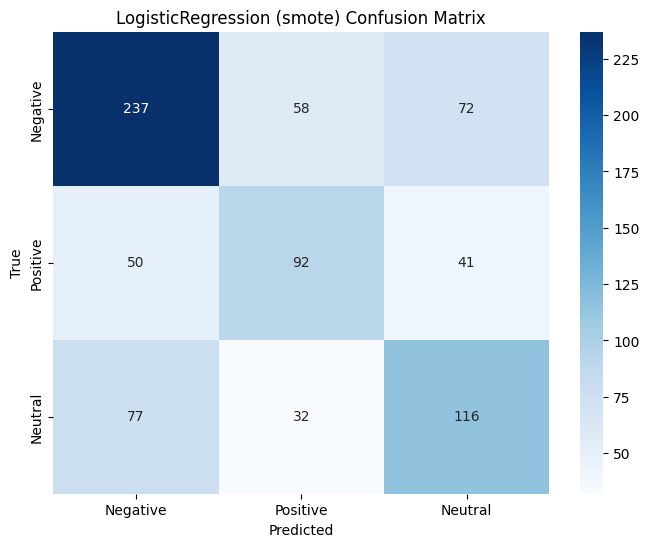

2025-06-24 06:53:34,060 - INFO - Saved confusion matrix: LogisticRegression_smote_cm.png


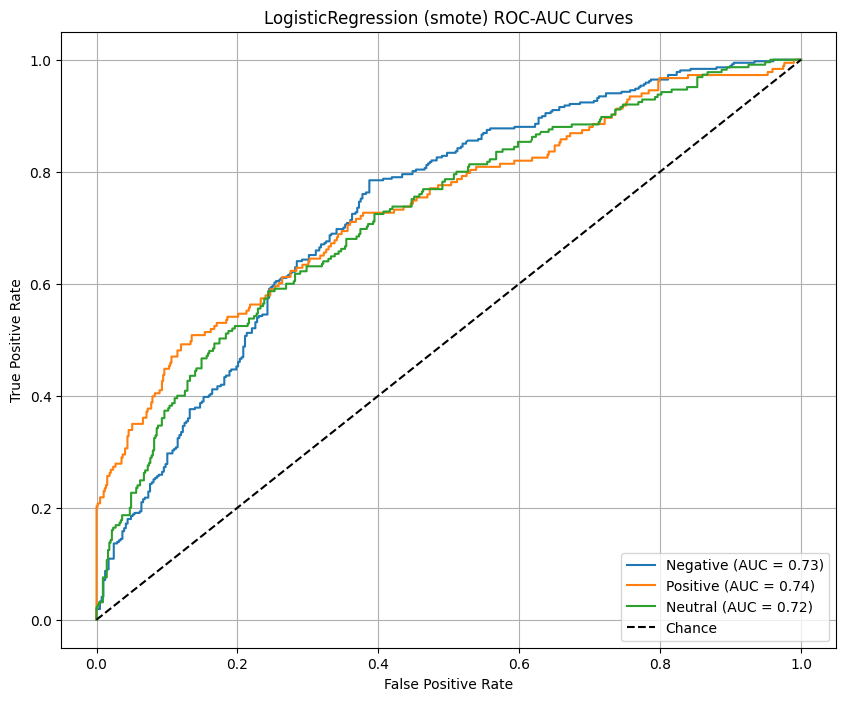

2025-06-24 06:53:34,410 - INFO - Saved ROC-AUC plot: LogisticRegression_smote_roc_auc.png


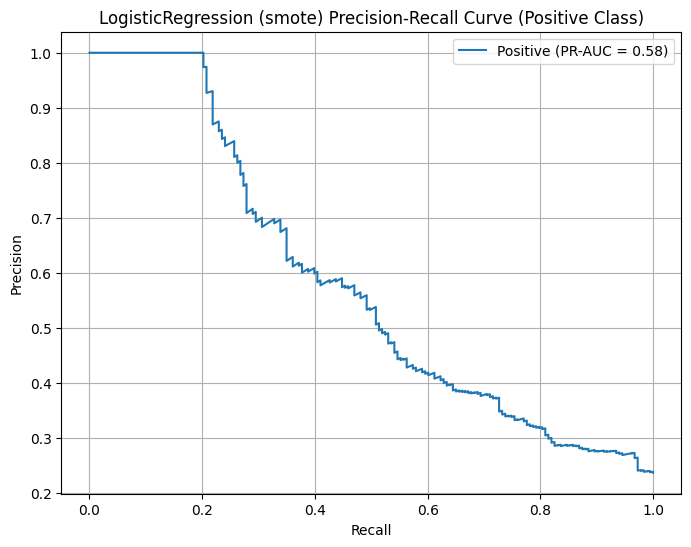

2025-06-24 06:53:34,667 - INFO - Saved PR curve: LogisticRegression_smote_pr_curve.png
2025-06-24 06:53:34,670 - INFO - Loaded model: LogisticRegression_undersampled_tuned.joblib


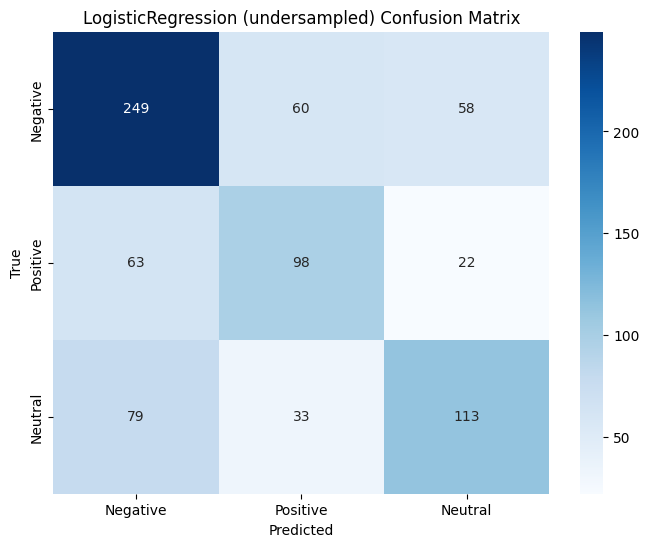

2025-06-24 06:53:34,914 - INFO - Saved confusion matrix: LogisticRegression_undersampled_cm.png


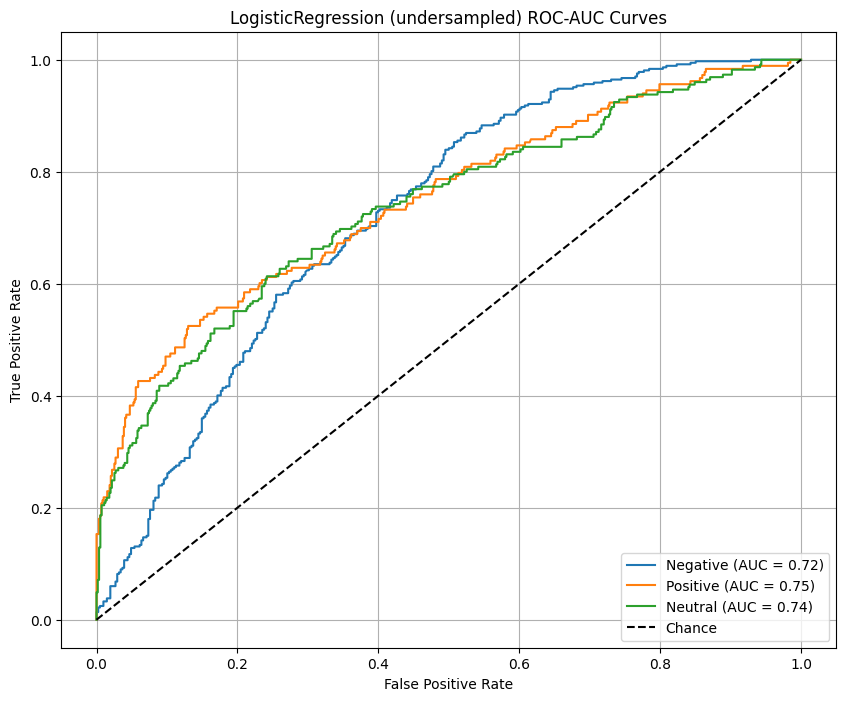

2025-06-24 06:53:35,218 - INFO - Saved ROC-AUC plot: LogisticRegression_undersampled_roc_auc.png


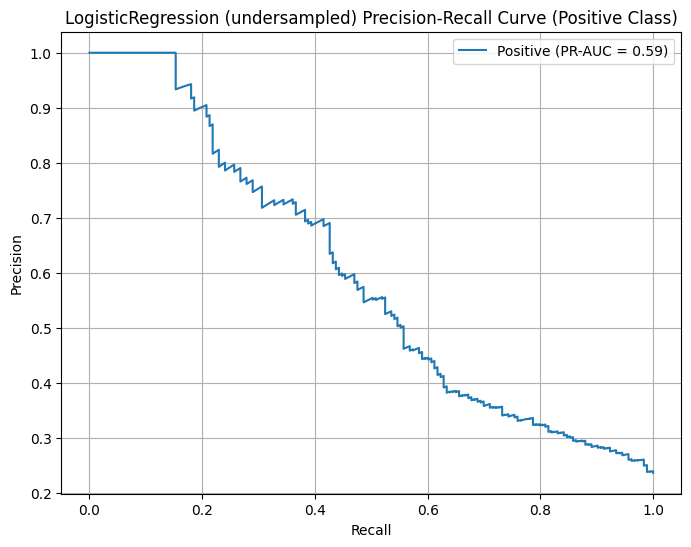

2025-06-24 06:53:35,492 - INFO - Saved PR curve: LogisticRegression_undersampled_pr_curve.png
2025-06-24 06:53:35,495 - INFO - Loaded model: LogisticRegression_nearmiss_tuned.joblib


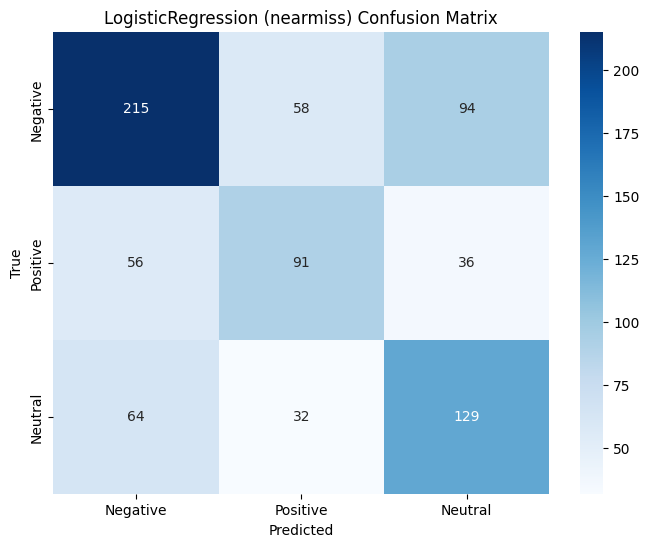

2025-06-24 06:53:35,787 - INFO - Saved confusion matrix: LogisticRegression_nearmiss_cm.png


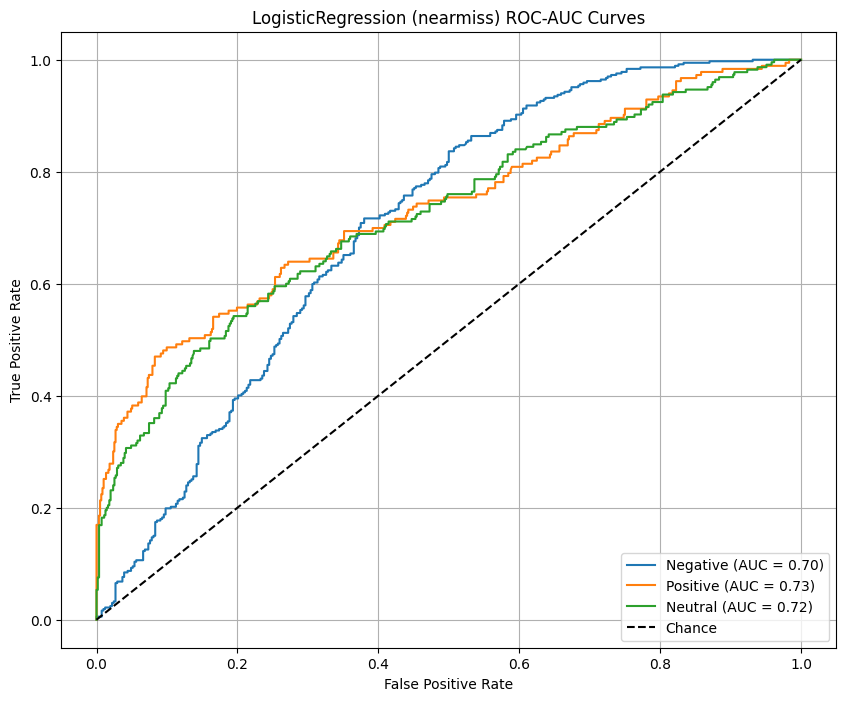

2025-06-24 06:53:36,129 - INFO - Saved ROC-AUC plot: LogisticRegression_nearmiss_roc_auc.png


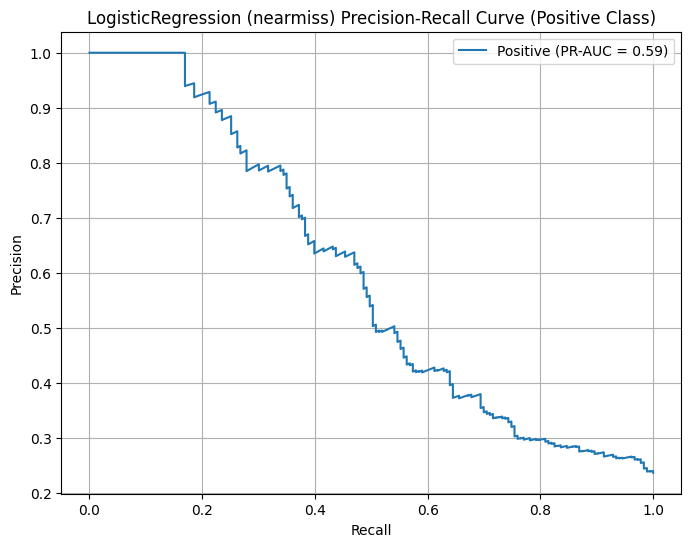

2025-06-24 06:53:36,403 - INFO - Saved PR curve: LogisticRegression_nearmiss_pr_curve.png
2025-06-24 06:53:36,405 - INFO - Loaded model: LogisticRegression_weighted_tuned.joblib


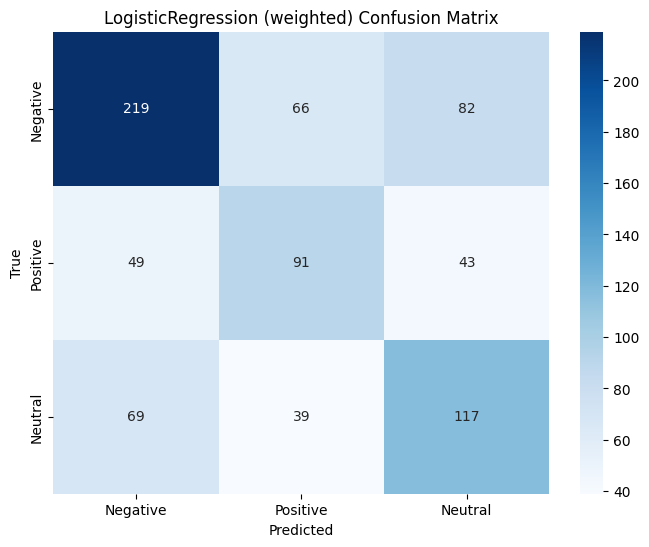

2025-06-24 06:53:36,738 - INFO - Saved confusion matrix: LogisticRegression_weighted_cm.png


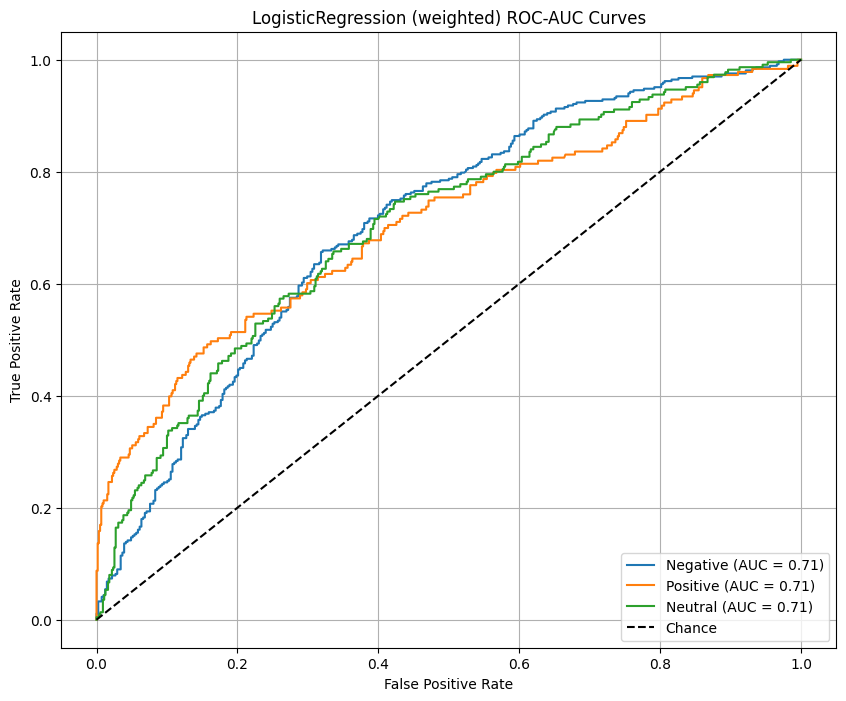

2025-06-24 06:53:37,154 - INFO - Saved ROC-AUC plot: LogisticRegression_weighted_roc_auc.png


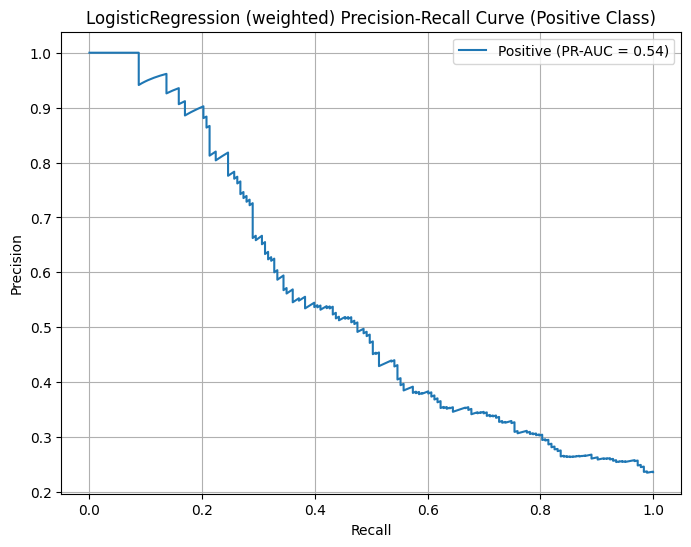

2025-06-24 06:53:37,552 - INFO - Saved PR curve: LogisticRegression_weighted_pr_curve.png
Evaluating Models:  25%|██▌       | 1/4 [00:03<00:11,  3.91s/it]2025-06-24 06:53:37,571 - INFO - Loaded model: SVM_smote_tuned.joblib


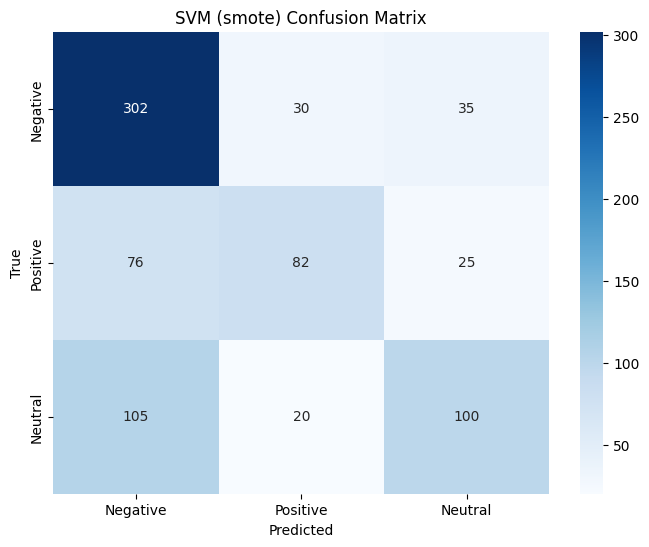

2025-06-24 06:53:39,527 - INFO - Saved confusion matrix: SVM_smote_cm.png


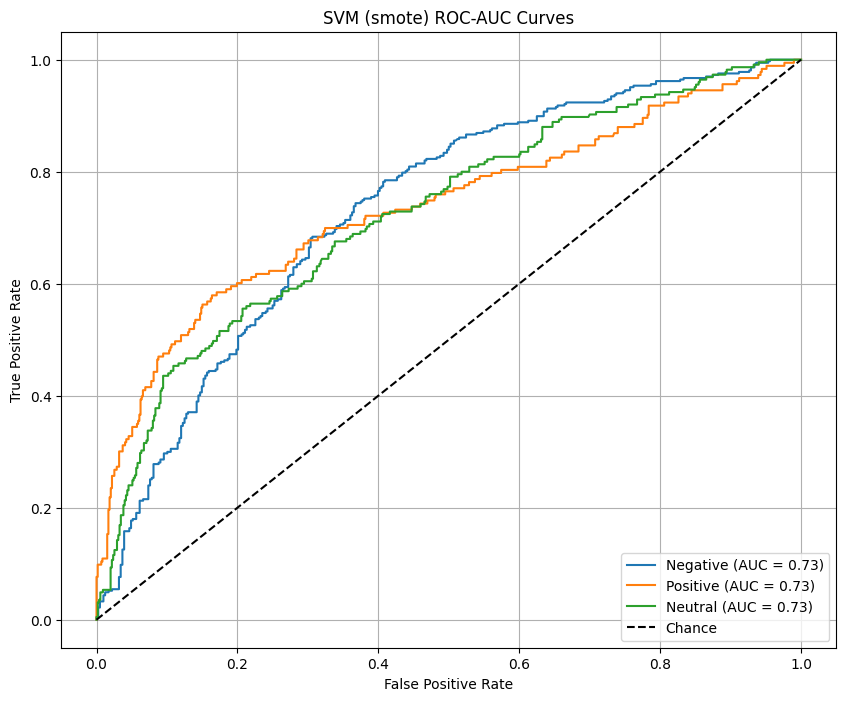

2025-06-24 06:53:40,087 - INFO - Saved ROC-AUC plot: SVM_smote_roc_auc.png


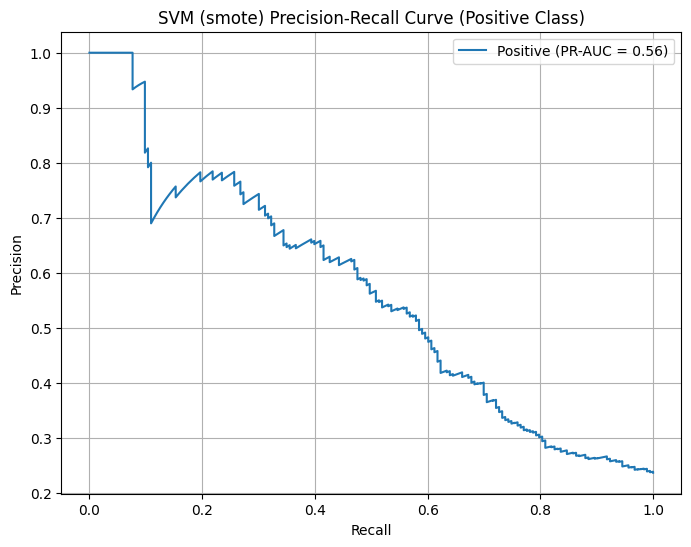

2025-06-24 06:53:41,383 - INFO - Saved PR curve: SVM_smote_pr_curve.png
2025-06-24 06:53:41,393 - INFO - Loaded model: SVM_undersampled_tuned.joblib


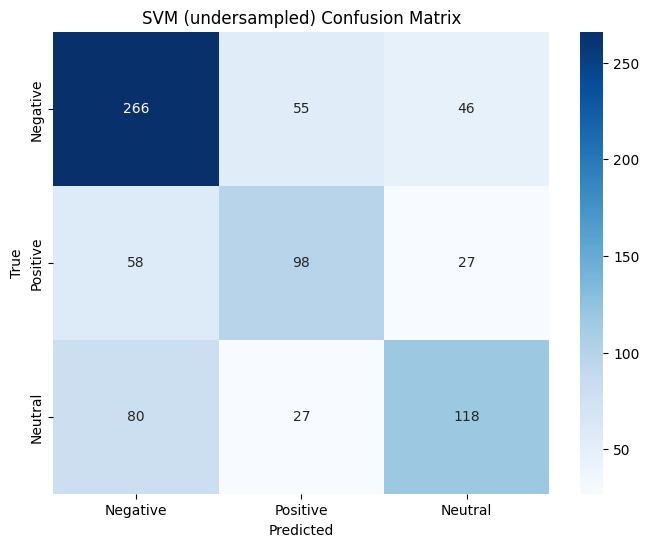

2025-06-24 06:53:42,688 - INFO - Saved confusion matrix: SVM_undersampled_cm.png


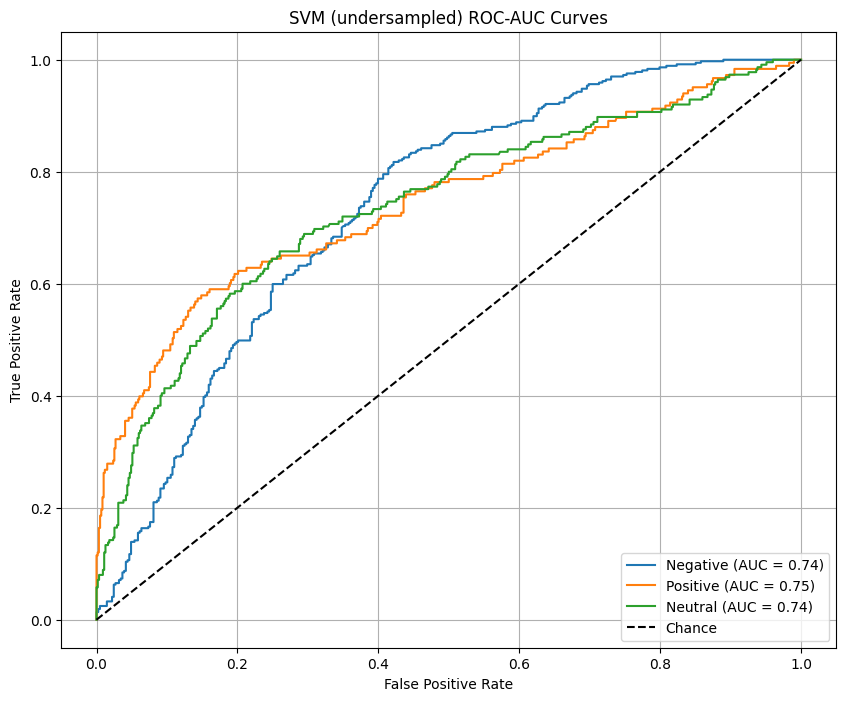

2025-06-24 06:53:43,296 - INFO - Saved ROC-AUC plot: SVM_undersampled_roc_auc.png


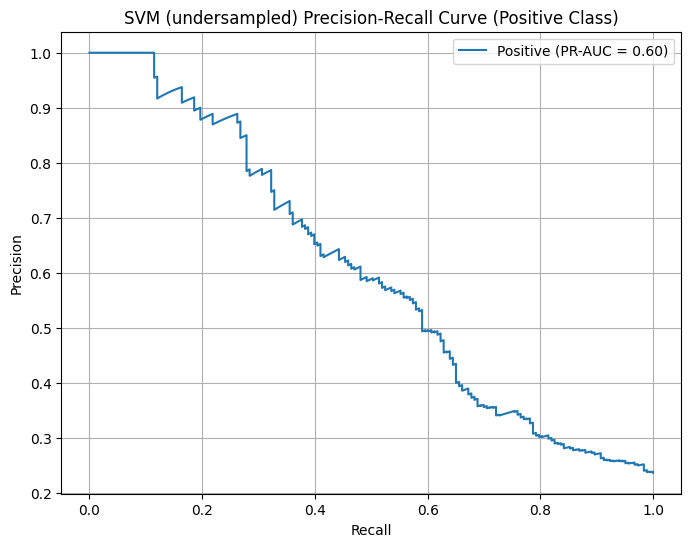

2025-06-24 06:53:43,726 - INFO - Saved PR curve: SVM_undersampled_pr_curve.png
2025-06-24 06:53:43,733 - INFO - Loaded model: SVM_nearmiss_tuned.joblib


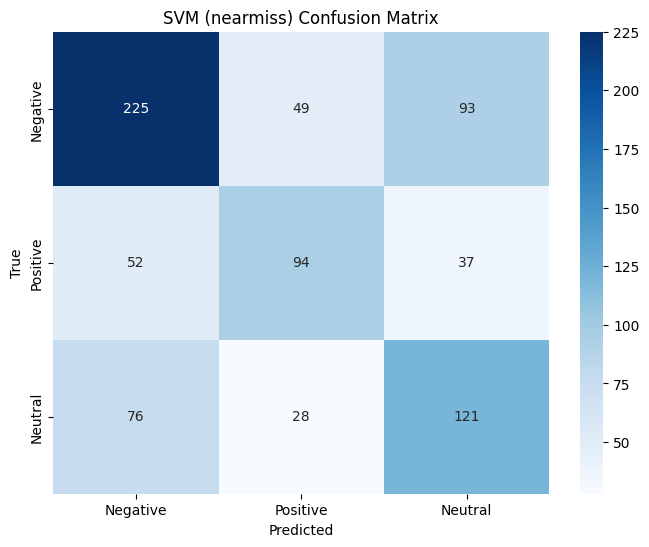

2025-06-24 06:53:47,587 - INFO - Saved confusion matrix: SVM_nearmiss_cm.png


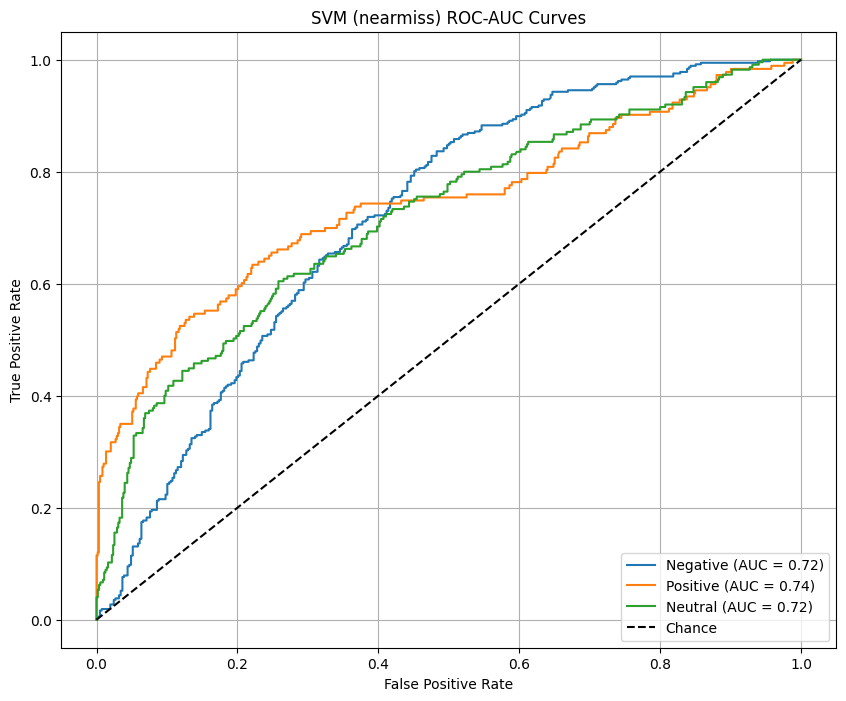

2025-06-24 06:53:47,991 - INFO - Saved ROC-AUC plot: SVM_nearmiss_roc_auc.png


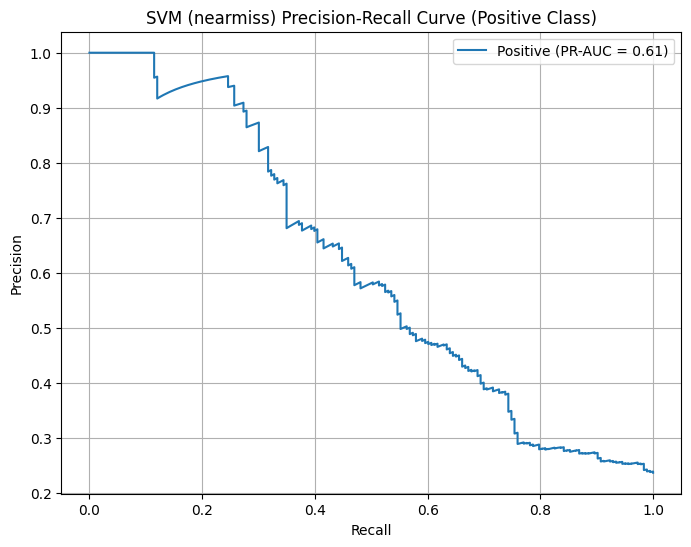

2025-06-24 06:53:48,336 - INFO - Saved PR curve: SVM_nearmiss_pr_curve.png
2025-06-24 06:53:48,341 - INFO - Loaded model: SVM_weighted_tuned.joblib


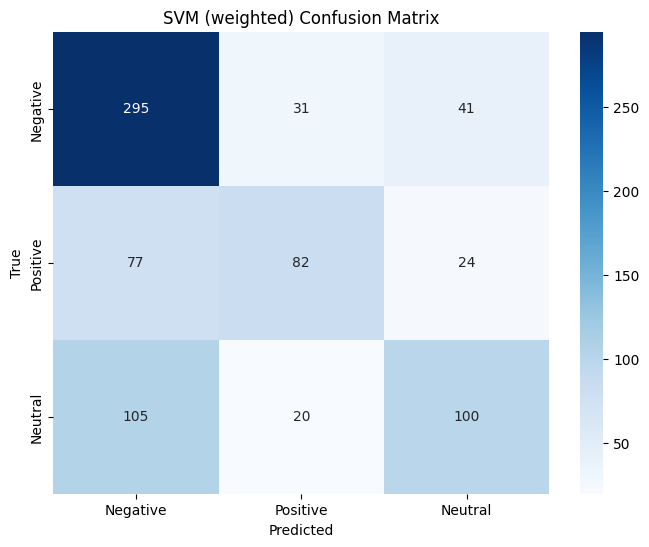

2025-06-24 06:53:49,885 - INFO - Saved confusion matrix: SVM_weighted_cm.png


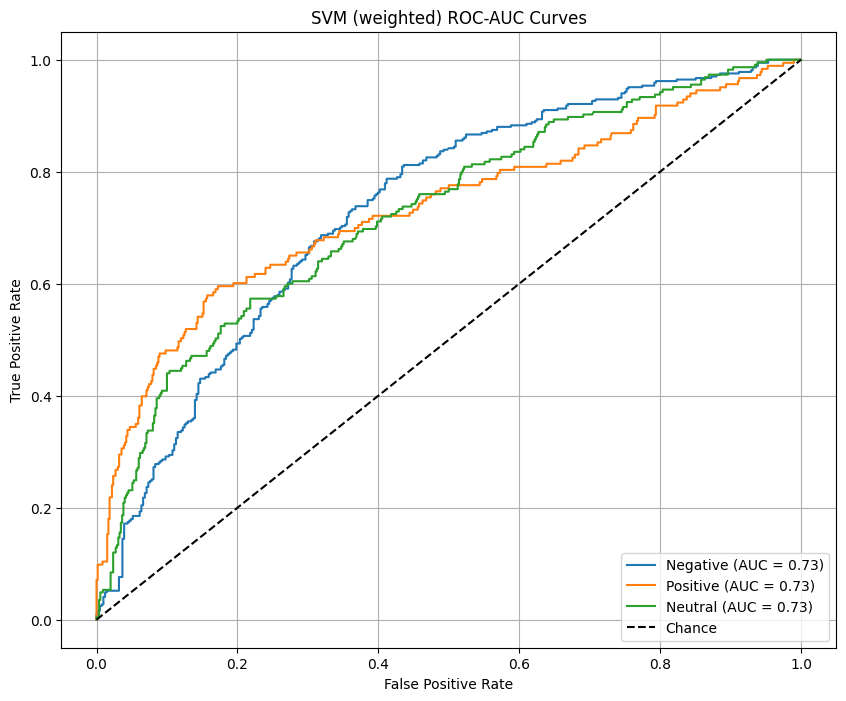

2025-06-24 06:53:50,328 - INFO - Saved ROC-AUC plot: SVM_weighted_roc_auc.png


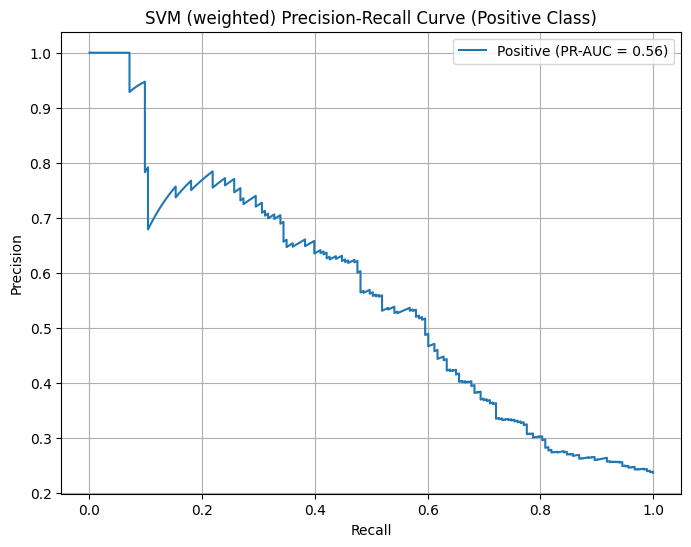

2025-06-24 06:53:50,664 - INFO - Saved PR curve: SVM_weighted_pr_curve.png
Evaluating Models:  50%|█████     | 2/4 [00:17<00:18,  9.32s/it]2025-06-24 06:53:50,669 - INFO - Loaded model: NaiveBayes_smote_tuned.joblib


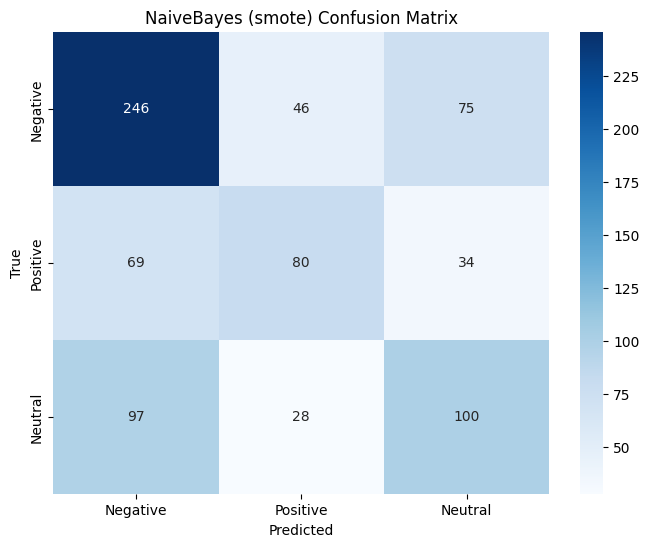

2025-06-24 06:53:50,968 - INFO - Saved confusion matrix: NaiveBayes_smote_cm.png


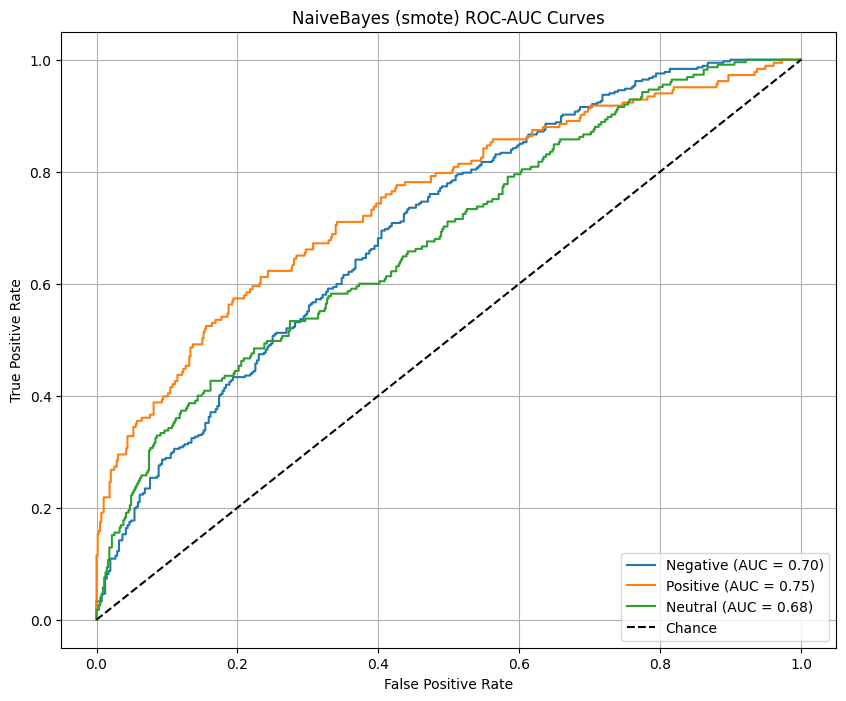

2025-06-24 06:53:51,353 - INFO - Saved ROC-AUC plot: NaiveBayes_smote_roc_auc.png


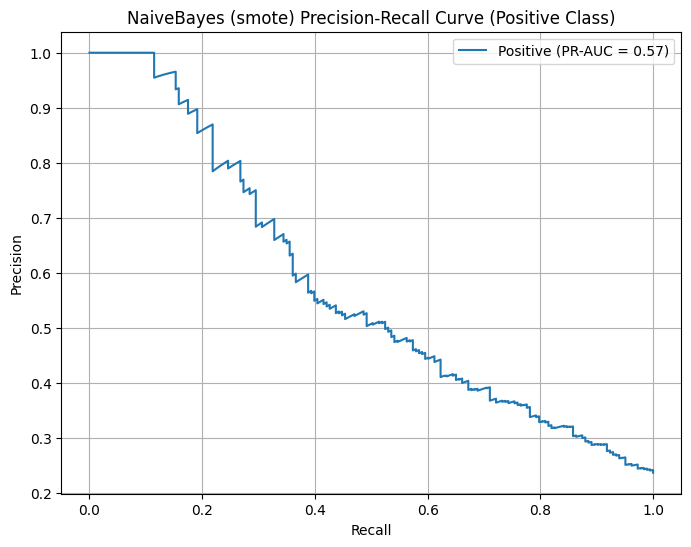

2025-06-24 06:53:51,867 - INFO - Saved PR curve: NaiveBayes_smote_pr_curve.png
2025-06-24 06:53:51,871 - INFO - Loaded model: NaiveBayes_undersampled_tuned.joblib


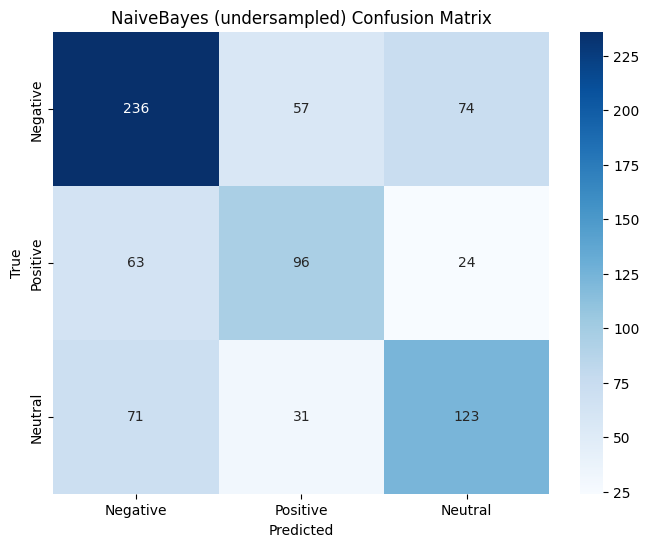

2025-06-24 06:53:52,241 - INFO - Saved confusion matrix: NaiveBayes_undersampled_cm.png


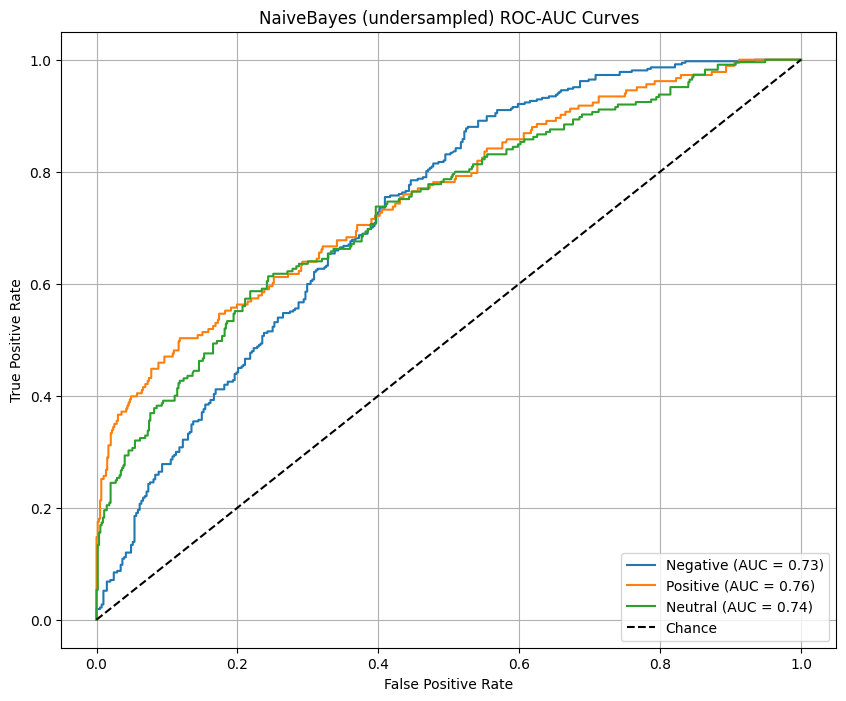

2025-06-24 06:53:52,649 - INFO - Saved ROC-AUC plot: NaiveBayes_undersampled_roc_auc.png


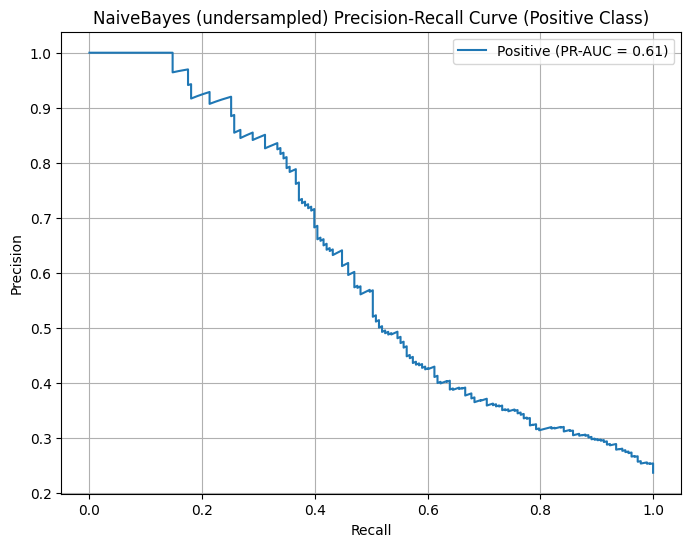

2025-06-24 06:53:53,083 - INFO - Saved PR curve: NaiveBayes_undersampled_pr_curve.png
2025-06-24 06:53:53,086 - INFO - Loaded model: NaiveBayes_nearmiss_tuned.joblib


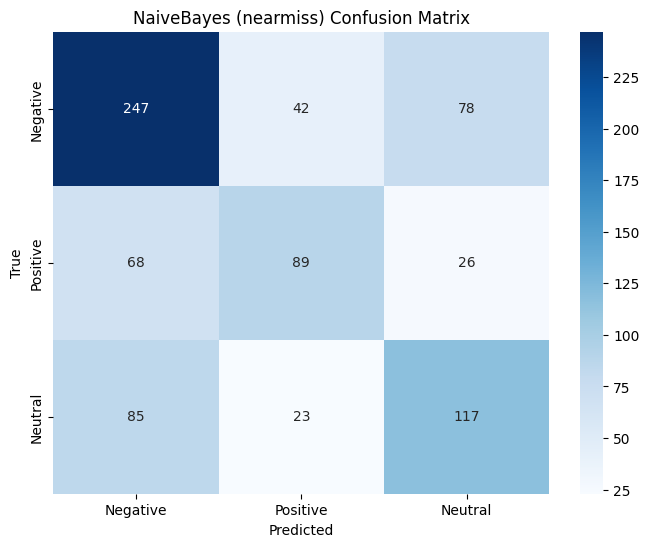

2025-06-24 06:53:53,413 - INFO - Saved confusion matrix: NaiveBayes_nearmiss_cm.png


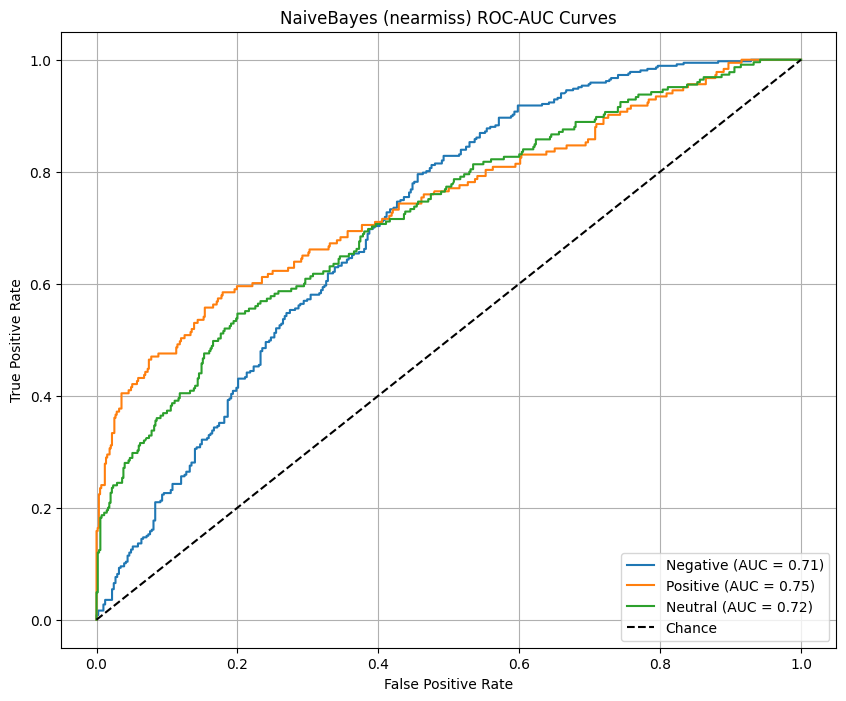

2025-06-24 06:53:53,807 - INFO - Saved ROC-AUC plot: NaiveBayes_nearmiss_roc_auc.png


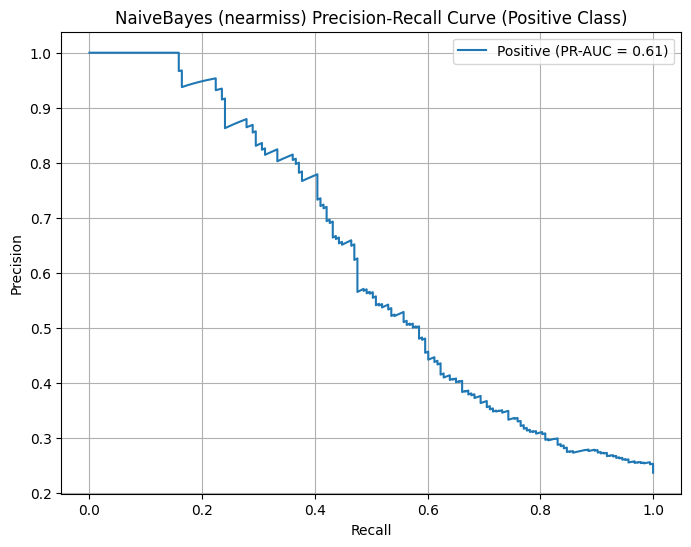

2025-06-24 06:53:54,306 - INFO - Saved PR curve: NaiveBayes_nearmiss_pr_curve.png
2025-06-24 06:53:54,309 - INFO - Loaded model: NaiveBayes_weighted_tuned.joblib


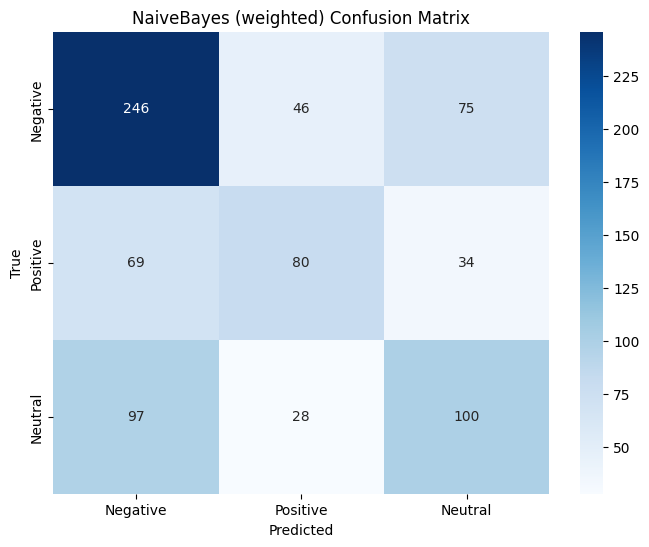

2025-06-24 06:53:54,703 - INFO - Saved confusion matrix: NaiveBayes_weighted_cm.png


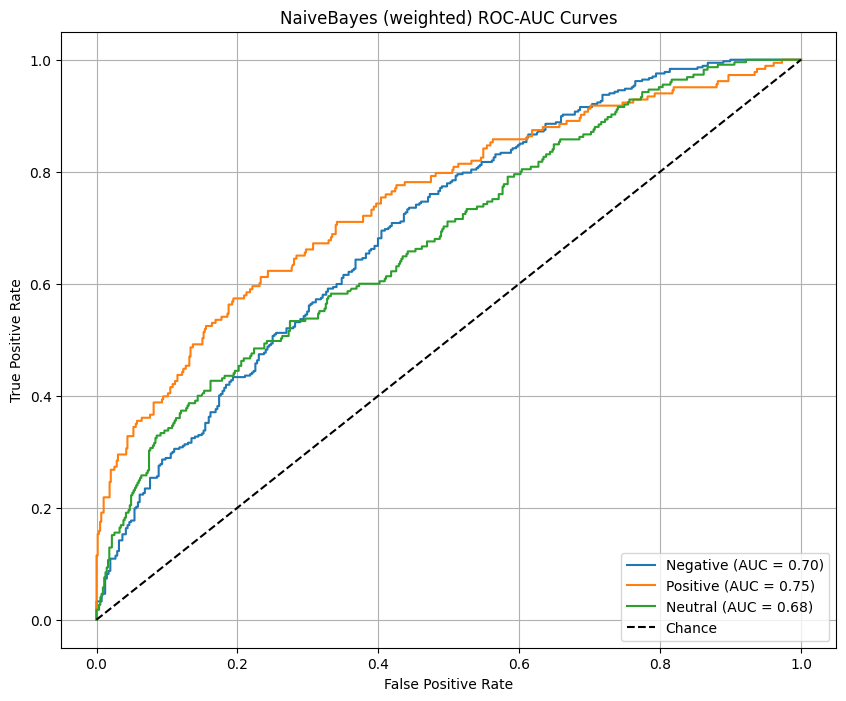

2025-06-24 06:53:55,213 - INFO - Saved ROC-AUC plot: NaiveBayes_weighted_roc_auc.png


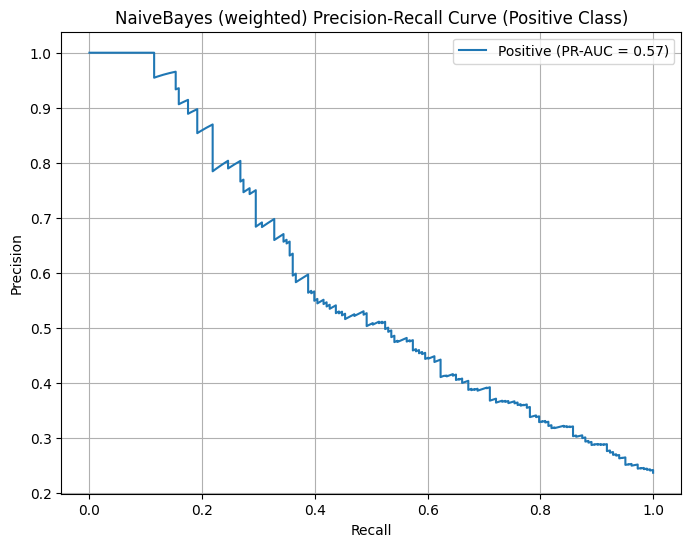

2025-06-24 06:53:55,694 - INFO - Saved PR curve: NaiveBayes_weighted_pr_curve.png
Evaluating Models:  75%|███████▌  | 3/4 [00:22<00:07,  7.36s/it]2025-06-24 06:53:56,798 - INFO - Loaded model: RandomForest_smote_tuned.joblib


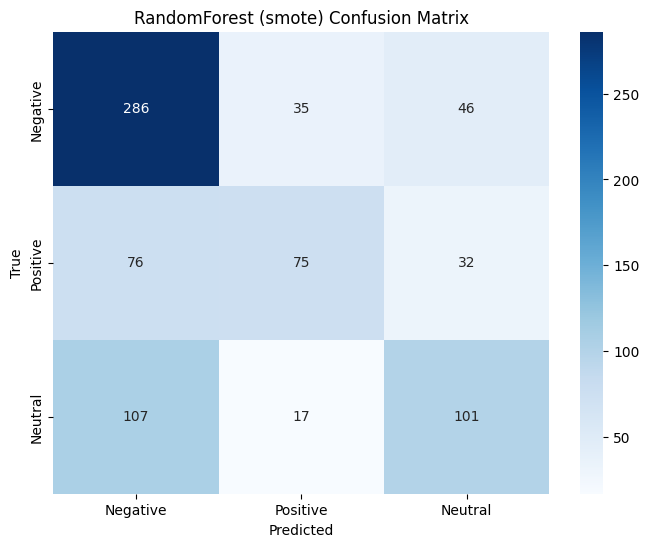

2025-06-24 06:53:57,303 - INFO - Saved confusion matrix: RandomForest_smote_cm.png


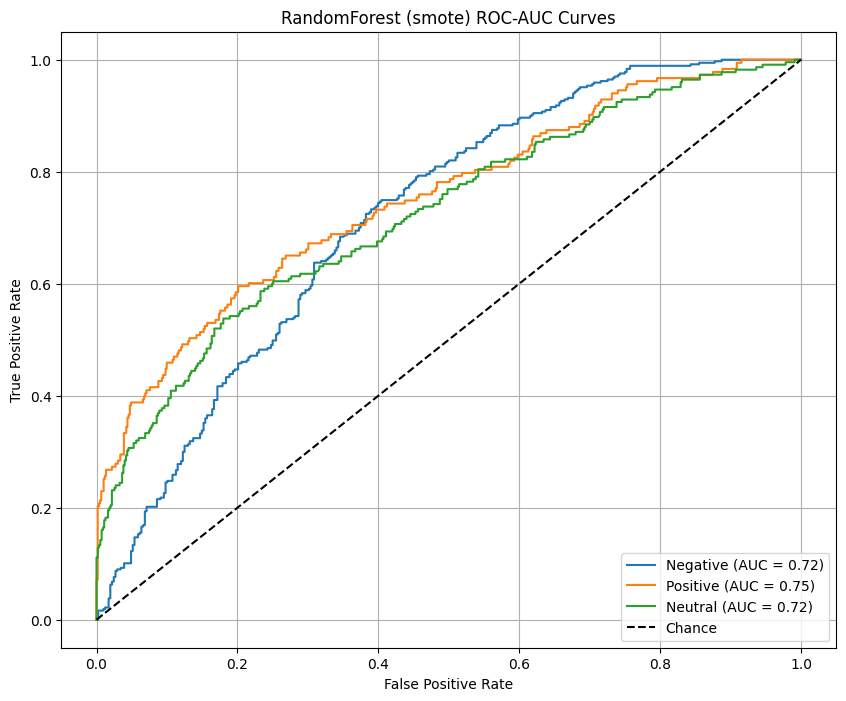

2025-06-24 06:53:57,786 - INFO - Saved ROC-AUC plot: RandomForest_smote_roc_auc.png


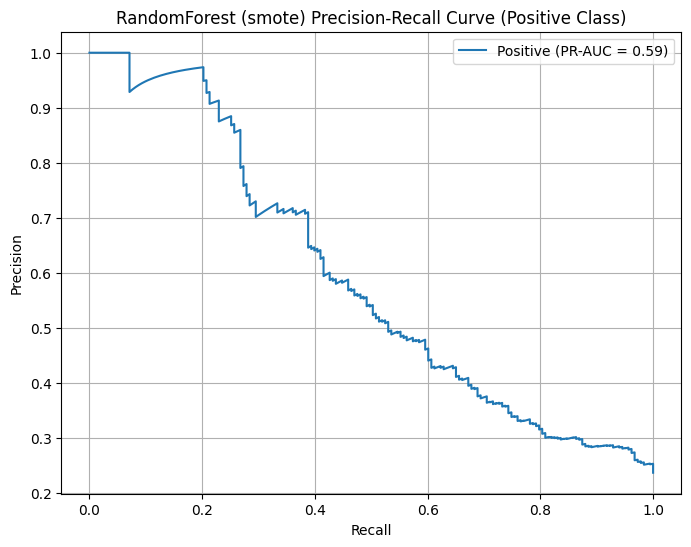

2025-06-24 06:53:58,132 - INFO - Saved PR curve: RandomForest_smote_pr_curve.png
2025-06-24 06:53:58,349 - INFO - Loaded model: RandomForest_undersampled_tuned.joblib


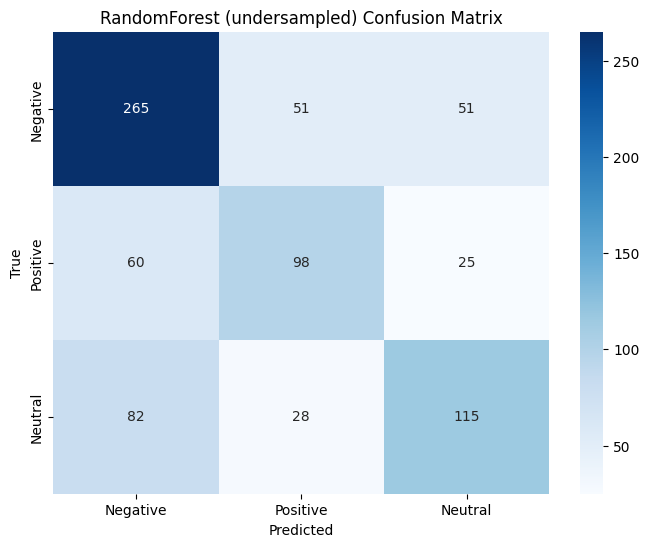

2025-06-24 06:53:58,775 - INFO - Saved confusion matrix: RandomForest_undersampled_cm.png


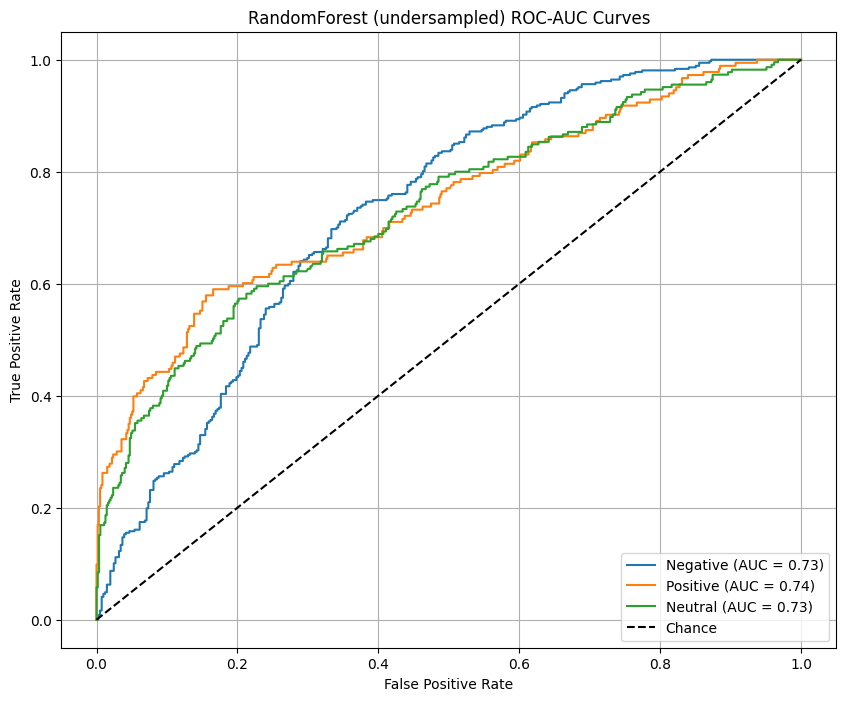

2025-06-24 06:53:59,288 - INFO - Saved ROC-AUC plot: RandomForest_undersampled_roc_auc.png


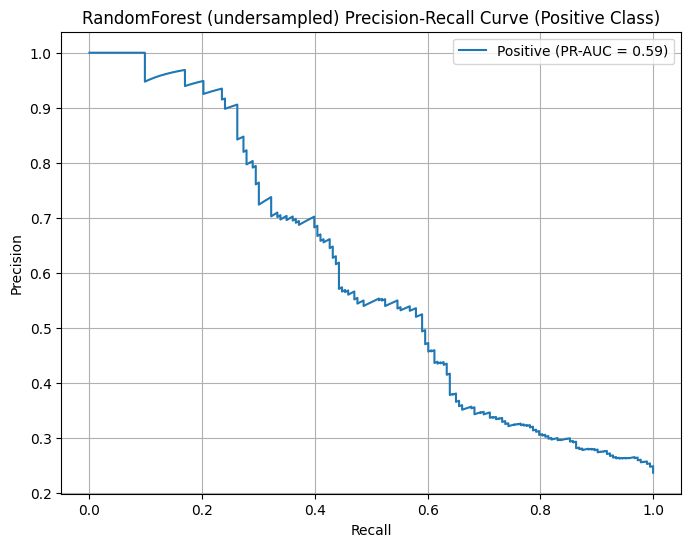

2025-06-24 06:53:59,838 - INFO - Saved PR curve: RandomForest_undersampled_pr_curve.png
2025-06-24 06:54:00,011 - INFO - Loaded model: RandomForest_nearmiss_tuned.joblib


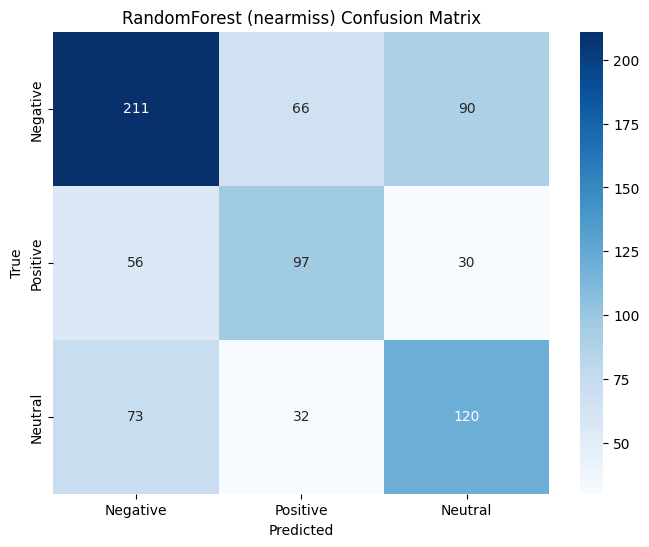

2025-06-24 06:54:00,449 - INFO - Saved confusion matrix: RandomForest_nearmiss_cm.png


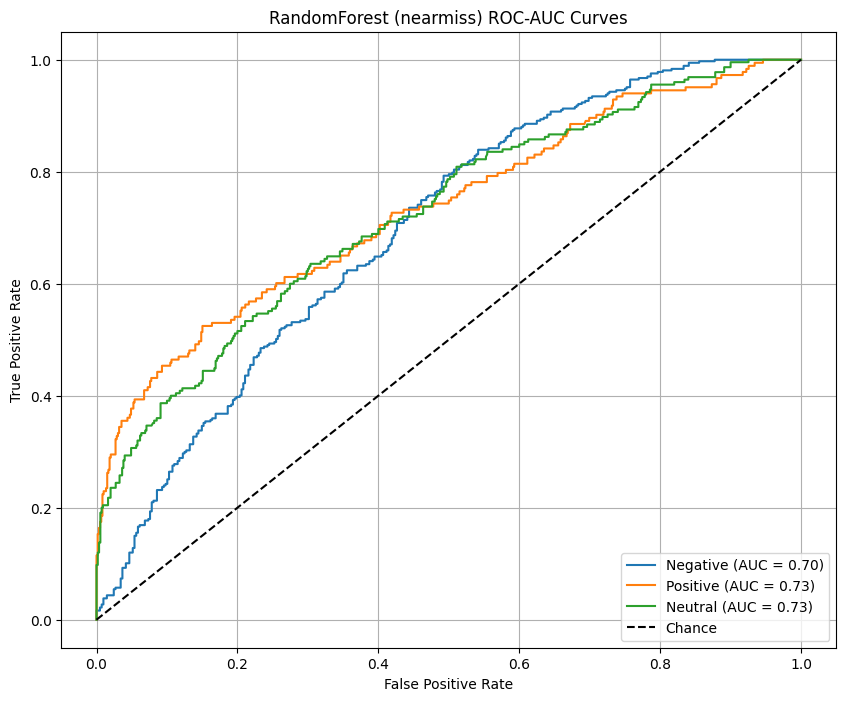

2025-06-24 06:54:00,852 - INFO - Saved ROC-AUC plot: RandomForest_nearmiss_roc_auc.png


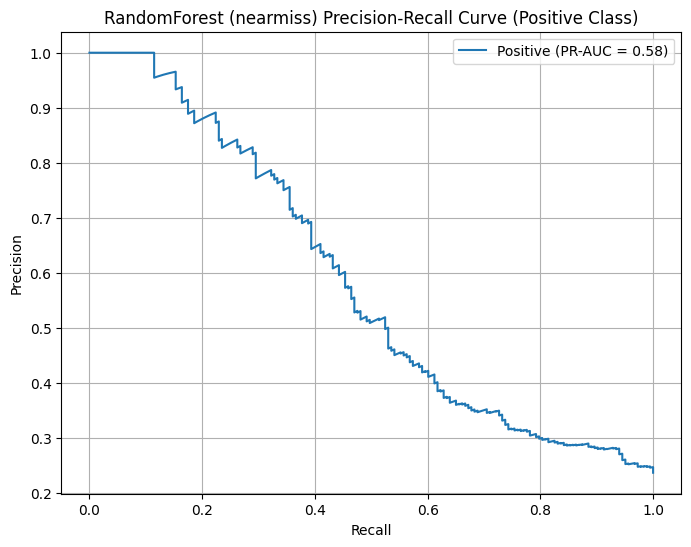

2025-06-24 06:54:01,302 - INFO - Saved PR curve: RandomForest_nearmiss_pr_curve.png
2025-06-24 06:54:01,764 - INFO - Loaded model: RandomForest_weighted_tuned.joblib


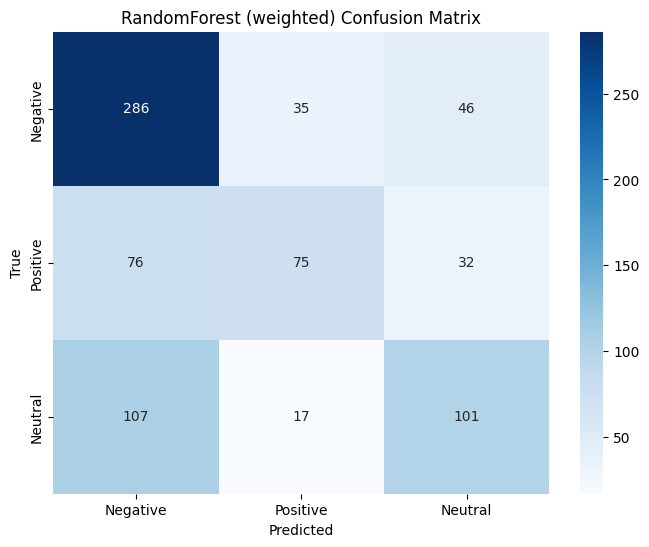

2025-06-24 06:54:02,323 - INFO - Saved confusion matrix: RandomForest_weighted_cm.png


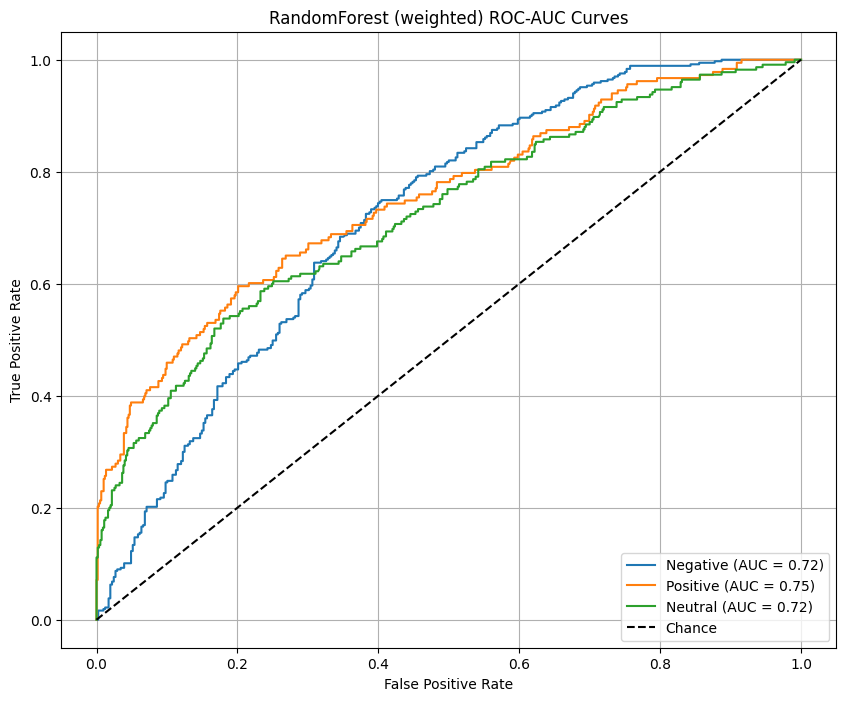

2025-06-24 06:54:02,882 - INFO - Saved ROC-AUC plot: RandomForest_weighted_roc_auc.png


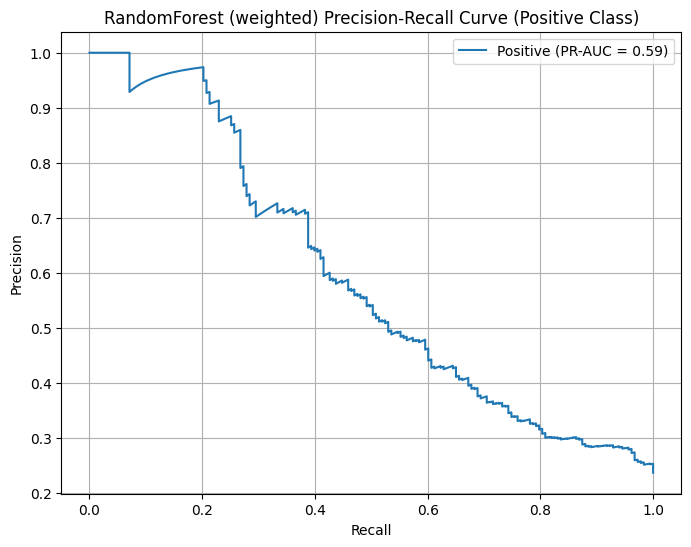

2025-06-24 06:54:03,252 - INFO - Saved PR curve: RandomForest_weighted_pr_curve.png
Evaluating Models: 100%|██████████| 4/4 [00:29<00:00,  7.40s/it]
2025-06-24 06:54:03,794 - INFO - Saved F1 comparison plot
2025-06-24 06:54:04,177 - INFO - Saved PR-AUC comparison plot
2025-06-24 06:54:04,179 - INFO - Test results saved: test_results.csv


In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    accuracy_score,
    precision_recall_fscore_support,
    auc,
    precision_recall_curve
)
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
import joblib
import logging

# Define class names
class_names = ['Negative', 'Positive', 'Neutral']

# Initialize results
f1_scores = {'Model': [], 'Mitigation': [], 'F1_Weighted': [], 'F1_Negative': [], 'F1_Positive': [], 'F1_Neutral': [], 'PR_AUC_Positive': []}
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

# Evaluate models
for name in tqdm(['LogisticRegression', 'SVM', 'NaiveBayes', 'RandomForest'], desc="Evaluating Models: "):
    for dataset_name in ['smote', 'undersampled', 'nearmiss', 'weighted']:
        try:
            model = joblib.load(f"models/mitigated_models/{name}_{dataset_name}_tuned.joblib")
            logging.info(f"Loaded model: {name}_{dataset_name}_tuned.joblib")
            y_pred = model.predict(tfidf_test)
            y_pred_proba = model.predict_proba(tfidf_test)

            # Compute metrics
            precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
            f1_per_class = precision_recall_fscore_support(y_test, y_pred)[2]
            precision_positive, recall_positive, _ = precision_recall_curve(y_test_bin[:, 1], y_pred_proba[:, 1])
            pr_auc_positive = auc(recall_positive, precision_positive)

            # Store results
            f1_scores['Model'].append(name)
            f1_scores['Mitigation'].append(dataset_name)
            f1_scores['F1_Weighted'].append(f1)
            f1_scores['F1_Negative'].append(f1_per_class[0])
            f1_scores['F1_Positive'].append(f1_per_class[1])
            f1_scores['F1_Neutral'].append(f1_per_class[2])
            f1_scores['PR_AUC_Positive'].append(pr_auc_positive)

            # Confusion Matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
            plt.title(f"{name} ({dataset_name}) Confusion Matrix")
            plt.xlabel("Predicted")
            plt.ylabel("True")
            plt.savefig(f"models/mitigated_models/{name}_{dataset_name}_cm.png")
            plt.show()
            plt.close()
            logging.info(f"Saved confusion matrix: {name}_{dataset_name}_cm.png")

            # ROC-AUC Curve
            plt.figure(figsize=(10, 8))
            for i in range(len(class_names)):
                fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
                auc_score = roc_auc_score(y_test_bin[:, i], y_pred_proba[:, i])
                plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc_score:.2f})")
            plt.plot([0, 1], [0, 1], 'k--', label='Chance')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f"{name} ({dataset_name}) ROC-AUC Curves")
            plt.legend(loc='lower right')
            plt.grid(True)
            plt.savefig(f"models/mitigated_models/{name}_{dataset_name}_roc_auc.png")
            plt.show()
            plt.close()
            logging.info(f"Saved ROC-AUC plot: {name}_{dataset_name}_roc_auc.png")

            # Precision-Recall Curve for Positive Class
            plt.figure(figsize=(8, 6))
            plt.plot(recall_positive, precision_positive, label=f'Positive (PR-AUC = {pr_auc_positive:.2f})')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title(f"{name} ({dataset_name}) Precision-Recall Curve (Positive Class)")
            plt.legend()
            plt.grid(True)
            plt.savefig(f"models/mitigated_models/{name}_{dataset_name}_pr_curve.png")
            plt.show()
            plt.close()
            logging.info(f"Saved PR curve: {name}_{dataset_name}_pr_curve.png")
        except Exception as e:
            logging.error(f"Error evaluating {name} ({dataset_name}): {str(e)}")

# Plot comparisons
f1_df = pd.DataFrame(f1_scores)
sns.barplot(x='Mitigation', y='F1_Weighted', hue='Model', data=f1_df)
plt.title("Weighted F1 Comparison Across Mitigation Strategies")
plt.savefig("models/mitigated_models/f1_comparison_weighted.png")
plt.close()
logging.info("Saved F1 comparison plot")

sns.barplot(x='Mitigation', y='PR_AUC_Positive', hue='Model', data=f1_df)
plt.title("Precision-Recall AUC (Positive Class) Comparison")
plt.savefig("models/mitigated_models/pr_auc_positive_comparison.png")
plt.close()
logging.info("Saved PR-AUC comparison plot")

# Save results
f1_df.to_csv("models/mitigated_models/test_results.csv")
logging.info("Test results saved: test_results.csv")

In [14]:
# Update README
with open("models/mitigated_models/README.txt", "w", encoding='utf-8') as f:
    f.write("Mitigated Model Outputs:\n"
            "- mitigated_datasets/*.npz, *.csv: SMOTE, Undersampled, NearMiss datasets\n"
            "- models/mitigated_models/*_*.joblib: Trained models\n"
            "- models/mitigated_models/*_tuned.joblib: Tuned models\n"
            "- tuned_results.csv: Tuning results\n"
            "- test_results.csv: Test set metrics\n"
            "- *_cm.png: Confusion matrices\n"
            "- *_roc_auc.png: ROC-AUC curves\n"
            "- *_pr_curve.png: Precision-recall curves\n"
            "- f1_comparison_*.png: F1 comparison plots\n"
            "- pr_auc_positive_comparison.png: PR-AUC comparison")
logging.info("README updated")

2025-06-24 06:58:43,249 - INFO - README updated
